### Машинное обучение
## Домашнее задание №3 - Градиентный бустинг

**Общая информация**

**Срок сдачи:** 16 февраля 2023, 08:30   
**Штраф за опоздание:** -2 балла за каждые сутки

Используйте данный Ipython Notebook при оформлении домашнего задания.

##  Считаем производные для функций потерь (1 балл)

Мы будем реализовать градиентный бустинг для 3 функций потерь:

1) MSE  $L(a(x_i), y_i) = (y_i - a(x_i)) ^ 2$

2) Экспоненциальная  $L(a(x_i), y_i) = exp( -a(x_i) y_i), y_i \in \{-1, 1\}$

3) Логистическая  $L(a(x_i), y_i) = \log (1 + exp( -a(x_i) y_i)), y_i \in \{-1, 1\}$

где $a(x_i)$ предсказание бустинга на итом объекте. 

Для каждой функции потерь напишите таргет, на который будет настраиваться каждое дерево в бустинге. 

Ваше решение тут

##  Реализуем градиентный бустинг (3 балла)

Реализуйте класс градиентного бустинга для классификации. Ваша реализация бустинга должна работать по точности не более чем на 5 процентов хуже чем GradientBoostingClassifier из sklearn. 


Детали реализации:

-- должно поддерживаться 3 функции потерь

-- сами базовые алгоритмы(деревья, линейные модели и тп) реализовать не надо, просто возьмите готовые из sklearn

-- в качестве функции потерь для построения одного дерева используйте MSE

-- шаг в бустинге можно не подбирать, можно брать константный

-- можно брать разные модели в качестве инициализации бустинга

-- должны поддерживаться следующие параметры:

а) число итераций
б) размер шага
в) процент случайных фичей при построении одного дерева
д) процент случайных объектов при построении одного дерева
е) параметры базового алгоритма (передавайте через **kwargs)

In [13]:
import numpy as np
from sklearn.datasets import load_wine
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
import matplotlib.pyplot as plt

In [19]:
class MyGradientBoostingClassifier:

    def __init__(self, loss= "MSE", learning_rate = 0.1, n_estimators=100, colsample=1, subsample=1, *args, **kwargs):
        """
        loss -- один из 3 лоссов:
        learning_rate -- шаг бустинга
        n_estimators -- число итераций
        colsample -- процент рандомных признаков при обучнеии одного алгоритма
        colsample -- процент рандомных объектов при обучнеии одного алгоритма
        args, kwargs -- параметры  базовых моделей
        """
        self.loss = loss
        self.learning_rate = 0.1
        self.n_estimators = n_estimators
        self.colsample = colsample
        self.subsample = subsample
        self.args = args
        self.kwargs = kwargs
        self.list_model = []
        self.num_features = []
        self.F_x = None
        self.start_const = None
        self.start_model = None
        self.y_bi = False
    
    def new_y(self, y):
        if self.loss == "MSE":
            return -2*(self.F_x - y)
        elif self.loss == "log_loss":
            return y*np.exp(-self.F_x * y)
        else:
            return y*np.exp(-self.F_x * y)/(1 + np.exp(-self.F_x * y))
        
    
    
    def fit(self, X, y, base_model= DecisionTreeRegressor, init_model=None):
        """
        X -- объекты для обучения:
        y -- таргеты для обучения
        base_model -- класс базовых моделей, например sklearn.tree.DecisionTreeRegressor
        init_model -- класс для первой модели, если None то берем константу (только для посл задания)
        """
        X = np.asarray(X)
        y = np.asarray(y)
        if (np.unique(y)[0] == -1 and np.unique(y)[1] == 1):
            self.y_bi = True
        
        if init_model == None:
            index_str = np.sort(np.random.choice(y.size, int(y.size * self.subsample), replace=False))
            self.start_const = np.mean(y[index_str])
 
        else:
            clf = init_model()
            index_str = np.sort(np.random.choice(y.size, int(y.size * self.subsample), replace=False))
            clf.fit(X[index_str], y[index_str])
            self.start_model = clf

        for i in range(self.n_estimators):
            index_str = np.sort(np.random.choice(y.size, int(y.size * self.subsample), replace=False))
            index_col = np.sort(np.random.choice(X.shape[1], int(X.shape[1] * self.colsample), replace=False))
            
            if self.start_model == None:
                self.F_x = np.full(int(y.size * self.subsample), self.start_const)
            else:
                self.F_x = self.start_model.predict(X[index_str])
            for i, clf in enumerate(self.list_model):
                self.F_x += self.learning_rate * clf.predict(X[np.ix_(index_str, self.num_features[i])])
            self.F_x = np.asarray(self.F_x)    
                
            clf = base_model(*self.args, **self.kwargs)
            clf.fit(X[np.ix_(index_str, index_col)], self.new_y(y[index_str]))
            self.list_model.append(clf)
            self.num_features.append(index_col)
        
    def predict(self, X):
        X = np.asarray(X)
        if self.start_model == None:
            pred = np.full(X.shape[0], self.start_const)
        else:
            pred = self.start_model.predict(X)
        
        for i, clf in enumerate(self.list_model):
            pred += self.learning_rate * clf.predict(X[:,self.num_features[i]])
        if not(self.y_bi):
            return np.around(pred).astype(int)
        else:
            pred = np.asarray(pred)
            ind = np.abs(pred - 1) >= np.abs(pred + 1)
            ind = np.asarray(ind)
            pred[ind] = -1
            pred[np.logical_not(ind)] = 1
            return pred



In [20]:
my_clf = MyGradientBoostingClassifier()
clf = GradientBoostingClassifier()

In [21]:
wine = load_wine()
X_train, X_test, y_train, y_test = train_test_split(wine.data, wine.target, test_size=0.1, stratify=wine.target)

In [22]:
my_clf.fit(X_train, y_train)
clf.fit(X_train, y_train)
print(accuracy_score(y_pred=clf.predict(X_test), y_true=y_test))
print(accuracy_score(y_pred=my_clf.predict(X_test), y_true=y_test))

0.8888888888888888
0.8888888888888888


## Подбираем параметры (2 балла)

Давайте попробуем применить Ваш бустинг для предсказаний цены домов в Калифорнии. Чтобы можно было попробовтаь разные функции потерь, переведем по порогу таргет в 2 класса: дорогие и дешевые дома.

В задании нужно

1) Построить график точности в зависимости от числа итераций на валидации.

2) Подобрать оптимальные параметры Вашего бустинга на валидации. 


In [6]:
from sklearn.datasets import fetch_california_housing
X, y = fetch_california_housing(return_X_y=True)

In [7]:
X = np.asarray(X)
y = np.asarray(y)

In [8]:
# Превращаем регрессию в классификацию
y = (y > 2.0).astype(int)
print(X.shape, y.shape)

(20640, 8) (20640,)


In [9]:
parametrs_1 = { "n_estimators": [5, 10, 20, 30, 50, 70, 100]}
parametrs_2 = { "n_estimators": [10, 20, 30],
              "loss": ["MSE", "log_loss", "Exp"],
              "learning_rate": [0.1, 0.3, 0.5],
              "subsample": [0.5, 0.8, 1.0],
              "colsample": [0.5, 0.8, 1.0]}

In [10]:
kf = KFold(n_splits = 3, shuffle = True)
res = []
for n_est in parametrs_1["n_estimators"]:
    clf = MyGradientBoostingClassifier(n_estimators=n_est)
    ind = kf.split(X)
    scores = []
    for train_ind, test_ind in ind:
        clf.fit(X[train_ind], y[train_ind])
        scores.append(accuracy_score(y[test_ind], clf.predict(X[test_ind])))
    score = np.mean(np.array(scores))
    
    print("n_estimator = {}, Score = {}\n".format(n_est, score))
    res.append(score)

n_estimator = 5, Score = 0.9328488372093023

n_estimator = 10, Score = 0.9065891472868217

n_estimator = 20, Score = 0.8970445736434108

n_estimator = 30, Score = 0.8903100775193797

n_estimator = 50, Score = 0.8962209302325581

n_estimator = 70, Score = 0.89718992248062

n_estimator = 100, Score = 0.9002906976744186



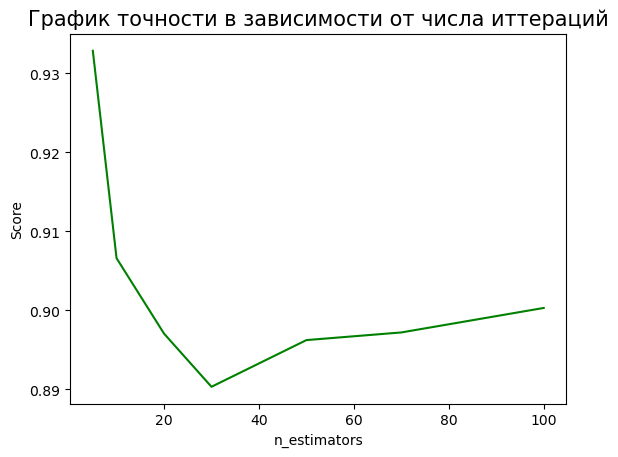

In [12]:
plt.xlabel("n_estimators")
plt.ylabel("Score")
plt.title("График точности в зависимости от числа иттераций", fontsize=15)
plt.plot(parametrs_1["n_estimators"], res, color="green")
plt.show()

Увеличение числа итераций градиентного бустинга уменьшает точность модели, но разброс меньше, чем 0.1 
Возможно это тренд, но на нашей выборке изменение незначительно

In [23]:
resv = []
best_model = {}
max_score = 0.0
for n_est in parametrs_2["n_estimators"]:
    for los in parametrs_2["loss"]:
        for learn_rate in parametrs_2["learning_rate"]:
            for subs in parametrs_2["subsample"]:
                for cols in parametrs_2["colsample"]:
                    clf = MyGradientBoostingClassifier(n_estimators=n_est, loss = los, 
                                                       learning_rate = learn_rate, subsample = subs,
                                                       colsample = cols)
                    ind = kf.split(X)
                    scores = []
                    for train_ind, test_ind in ind:
                        clf.fit(X[train_ind], y[train_ind])
                        scores.append(accuracy_score(y[test_ind], clf.predict(X[test_ind])))
                    score = np.mean(np.array(scores))
                    
                    if score > max_score:
                        best_model = {"n_estimators" : n_est, "loss" : los, "learning_rate" : learn_rate,
                                      "subsample" : subs, "colsample" : cols}
                        max_score = score
                    resv.append(score)

In [24]:
print(best_model)
print(max_score)

{'n_estimators': 20, 'loss': 'MSE', 'learning_rate': 0.3, 'subsample': 1.0, 'colsample': 0.8}
0.9618701550387597


## BooBag BagBoo (1 балл)



Попробуем объединить бустинг и бэгинг. Давайте

1) в качестве базовой модели брать не дерево решений, а случайный лес (из sklearn)

2) обучать N бустингов на бустрапированной выборке, а затем предикт усреднять

Попробуйте обе этих стратегии на данных из прошлого задания. Получилось ли улучшить качество? Почему?

In [ ]:
clf = MyGradientBoostingClassifier(**best_model)
ind = kf.split(X)
scores = []
for train_ind, test_ind in ind:
    clf.fit(X[train_ind], y[train_ind], base_model = RandomForestRegressor)
    scores.append(accuracy_score(y[test_ind], clf.predict(X[test_ind])))
score = np.mean(np.array(scores))
score
#качество не улучшилось, вычисления были ОЧЕНЬ долгие

In [26]:
def get_bootstrap_samples(X, y):
    indices = np.random.choice(y.size, y.size)
    samples = X[indices]
    y_new = y[indices]
    return samples, y_new

In [27]:
N = 7
scors = []
for i in range(N):
    data, new_y = get_bootstrap_samples(X, y)
    clf = MyGradientBoostingClassifier(**best_model)
    ind = kf.split(data)
    scores = []
    for train_ind, test_ind in ind:
        clf.fit(data[train_ind], new_y[train_ind])
        scores.append(accuracy_score(new_y[test_ind], clf.predict(data[test_ind])))
    score = np.mean(np.array(scores))
    scors.append(score)

In [28]:
scors = np.asarray(scors)
scors.mean()
#Усреднение 7 бустингов дало небольшой прирост в качестве, 
#но потребовалось больше времени, чтобы обучить модель и предсказать результат. 

0.9762942967884829

## Умная инициализация (1 балл)

Попробуйте брать в качестве инициализации бустинга не константу, а какой-то алгоритм и уже от его предикта стартовать итерации бустинга. Попробуйте разные модели из sklearn: линейные модели, рандом форест, svm..

Получилось ли улучшить качество? Почему?



In [29]:
clf = MyGradientBoostingClassifier(**best_model)
ind = kf.split(X)
scores = []
for train_ind, test_ind in ind:
    clf.fit(X[train_ind], y[train_ind], init_model = RandomForestRegressor)
    scores.append(accuracy_score(y[test_ind], clf.predict(X[test_ind])))
score = np.mean(np.array(scores))
score

0.9326065891472869

In [30]:
clf = MyGradientBoostingClassifier(**best_model)
ind = kf.split(X)
scores = []
for train_ind, test_ind in ind:
    clf.fit(X[train_ind], y[train_ind], init_model = LinearRegression)
    scores.append(accuracy_score(y[test_ind], clf.predict(X[test_ind])))
score = np.mean(np.array(scores))
score

0.9626453488372092

In [31]:
clf = MyGradientBoostingClassifier(**best_model)
ind = kf.split(X)
scores = []
for train_ind, test_ind in ind:
    clf.fit(X[train_ind], y[train_ind], init_model = SVR)
    scores.append(accuracy_score(y[test_ind], clf.predict(X[test_ind])))
score = np.mean(np.array(scores))
score
#Умная инициализация не показала прироста качества модели, но значительно увеличилась скорость обучения на SVM.

0.95484496124031

## Фидбек (бесценно)

* Какие аспекты обучения  ансамблей Вам показались непонятными? Какое место стоит дополнительно объяснить?

### Ваш ответ здесь

* Здесь Вы можете оставить отзыв о этой домашней работе или о всем курсе.

### ВАШ ОТЗЫВ ЗДЕСЬ



In [ ]:
Есть непонятные аспекты со стороны матана